# Representing image using matching pursuit with non-Gaussian basis functions

This notebook uses a variant of the matching pusuit algorithm (Elad, 2014) to decompose a frame from a microscopy video into a weighted sum of non-Gaussian basis functions.

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.util import img_as_float, img_as_uint
from skimage.filters import threshold_otsu
from scipy import ndimage
from scipy.stats import multivariate_normal

from otimage import io, imagerep, utils, viewers

## Load Zimmer data

### Load frame from file

In [3]:
# Path to file containing Zimmer data
in_fpath = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'

# Index of frame to use
t_frame = 5

with io.ZimmerReader(in_fpath) as reader:
    units = reader.units
    frame = reader.get_frame(t_frame)

### Select section of frame for test image

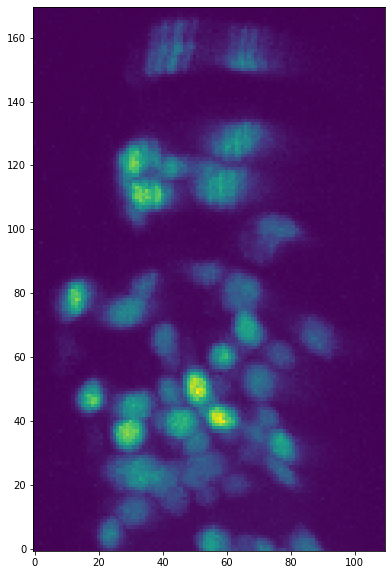

In [4]:
# Section of XY plane where head is found
(xmin, xmax) = (420, 530)
(ymin, ymax) = (350, 520)

# Extract section
img = frame[xmin:xmax, ymin:ymax, :]

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.figure(figsize=(10, 10))
plt.imshow(np.max(img, 2).T, origin='lower');

## Create filters

### Plot single cell

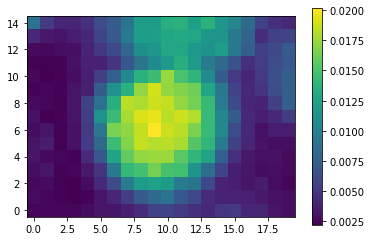

In [5]:
# Section of XY plane where cell is found
(xmin, xmax) = (20, 40)
(ymin, ymax) = (30, 45)

# Extract section
img_cell = img[xmin:xmax, ymin:ymax, :]

# Display max projection
plt.figure()
plt.imshow(np.max(img_cell, 2).T, origin='lower')
plt.colorbar()

### Gaussian filter

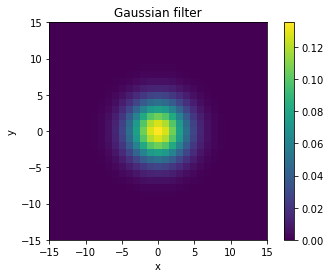

In [6]:
wx = 15
wy = 15
wz = 5
xg, yg, zg = np.mgrid[-wx:wx+1, -wy:wy+1, -wz:wz+1]
weight_grid = np.stack((xg, yg, zg), axis=-1)

mean = np.array([0, 0, 0]) 
cov = np.diag([8.0, 8.0, 1.5])
fl_gauss_nn = multivariate_normal.pdf(weight_grid, mean=mean, cov=cov)
fl_gauss = fl_gauss_nn / np.sqrt(np.sum(fl_gauss_nn ** 2))

plt.imshow(np.max(fl_gauss, 2).T, origin='lower', extent=[-15, 15, -15, 15])
plt.title('Gaussian filter')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar();

### Truncated Gaussian filter

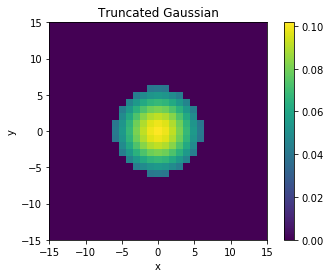

In [7]:
wx = 15
wy = 15
wz = 5
xg, yg, zg = np.mgrid[-wx:wx+1, -wy:wy+1, -wz:wz+1]
weight_grid = np.stack((xg, yg, zg), axis=-1)

mean = np.array([0, 0, 0]) 
cov = np.diag([20.0, 20.0, 1.5])
threshold = 0.001
fl_trunc = multivariate_normal.pdf(weight_grid, mean=mean, cov=cov)
fl_trunc[fl_trunc < threshold] = 0.0
fl_trunc = fl_trunc / np.sqrt(np.sum(fl_trunc ** 2))

plt.imshow(np.max(fl_trunc, 2).T, origin='lower', extent=[-15, 15, -15, 15])
plt.title('Truncated Gaussian')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar();

In [8]:
%%time
pts, wts, img_conv = imagerep.greedy_mp(img, fl_trunc, 1)

CPU times: user 901 ms, sys: 15.8 ms, total: 916 ms
Wall time: 915 ms


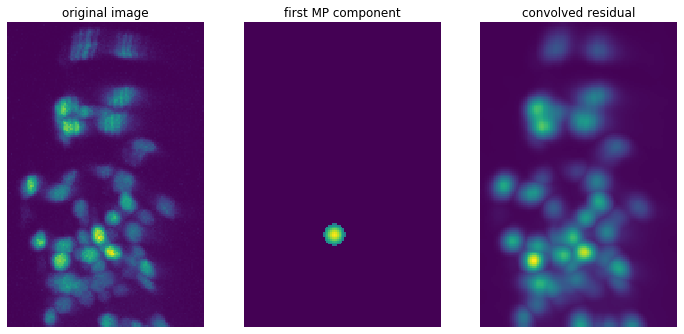

In [9]:
img_rep = np.zeros((img.shape[0] + 2 * wx, img.shape[1] + 2 * wy, img.shape[2] + 2 * wz))

pt = pts[0]
pt_mod = pt + np.array([wx, wy, wz])
x_sl = slice(pt_mod[0] - wx, pt_mod[0] + wx + 1)
y_sl = slice(pt_mod[1] - wy, pt_mod[1] + wy + 1)
z_sl = slice(pt_mod[2] - wz, pt_mod[2] + wz + 1)
img_rep[x_sl, y_sl, z_sl] = wts[0] * fl_trunc
img_rep = img_rep[wx:-wx, wy:-wy, wz:-wz]

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(np.max(img, 2).T, origin='lower');
plt.axis('off');
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(img_rep, 2).T, origin='lower')
plt.axis('off')
plt.title('first MP component');

plt.subplot(133)
plt.imshow(np.max(img_conv, 2).T, origin='lower')
plt.axis('off')
plt.title('convolved residual');

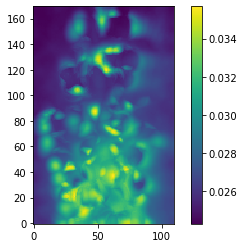

In [10]:
pts, wts, img_conv = imagerep.greedy_mp(img, fl_trunc, 200)

plt.imshow(np.max(img_conv, 2).T, origin='lower')
plt.colorbar()

In [11]:
recon_img = np.zeros((img.shape[0] + 2 * wx, img.shape[1] + 2 * wy, img.shape[2] + 2 * wz))
points_mod = pts + np.array([wx, wy, wz])

for i in range(points_mod.shape[0]):
    
    pt = points_mod[i]
    x_sl = slice(pt[0] - wx, pt[0] + wx + 1)
    y_sl = slice(pt[1] - wy, pt[1] + wy + 1)
    z_sl = slice(pt[2] - wz, pt[2] + wz + 1)
    
    recon_img[x_sl, y_sl, z_sl] += wts[i] * fl_trunc
    
r_img = recon_img[wx:-wx, wy:-wy, wz:-wz]

sq_err = np.sum((img - r_img) ** 2)
print(f'sq_err: {sq_err}')

sq_err: 1.7460370287048173


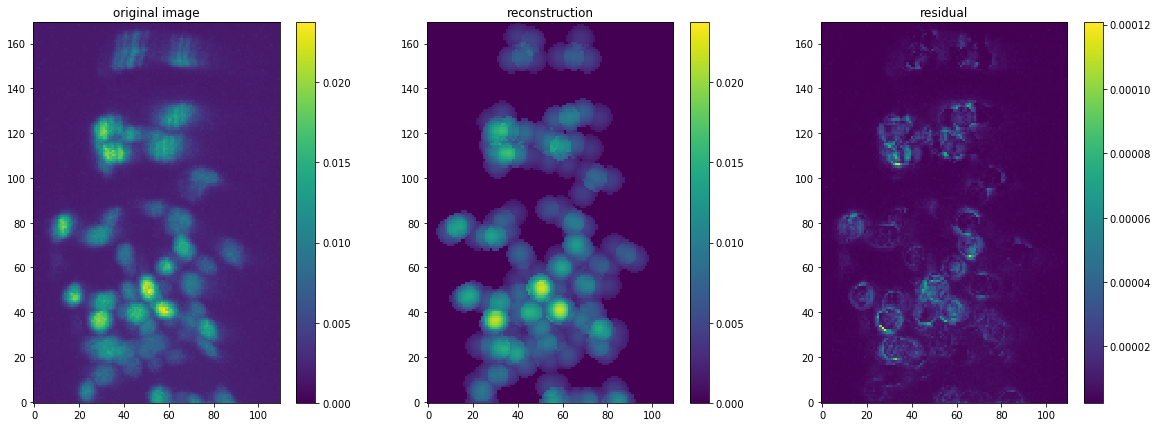

In [12]:
vmin = min(np.min(img), np.min(r_img))
vmax = max(np.max(img), np.max(r_img))

plt.figure(figsize=(20, 7))

plt.subplot(131)
plt.imshow(np.max(img, 2).T, origin='lower', vmin=vmin, vmax=vmax)
plt.title('original image')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.max(r_img, 2).T, origin='lower', vmin=vmin, vmax=vmax)
plt.title('reconstruction')
plt.colorbar()

sq_res_img = (r_img - img) ** 2
plt.subplot(133)
plt.imshow(np.max(sq_res_img, 2).T, origin='lower')
plt.title('residual')
plt.colorbar()

#plt.savefig('greedy_mp_1.png')